# Exercise 04 - Neural Networks for Regression in Keras

## Part II - Constructing and training a model

The main task of this exercise notebook is to build a neural network model of housing prices in California using the California census data. Our model should learn from this data and be able to predict the median housing price in any district, given all the other attributes.

* This task is a typical **supervised learning task**, since we are given **labeled training examples** (each instance comes with the expected
output, i.e., the district’s median housing price).
* The task is also a typical **regression task**, since we are asked to predict a **continuous real value**.
* More specifically, this is a **multiple regression problem** since the system will use **multiple features** to make a prediction (it
will use the district’s population, the median income, etc.).
* It is also a **univariate regression** problem since we are only trying to **predict a single value** for each district.

## Learning Objectives

- Learn how to configure a neural network architecture to solve a regression task, and in particular:
- Learn to define the output layer for regression task
- Learn to define activation functions for regression
- Understand the cost functions and metrics for regression
- Understand and practice weight and bias initialization in Keras
- Try out Batch Normalization Layers
- Learn how to take advantage of the logs dictionary in Keras
- Learn to define our own callbacks and check the progress of a model
- Understand and practice EarlyStoping 

Before you can start, find a GPU on the system that is not heavily used by other users (with **nvidia-smi**). Otherwise you cannot initialize your neural network.

In [331]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 6 # YOUR CHOICE

In [332]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')
USE_GPU = 6
# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.8.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:6 GPU


## California housing dataset

For more details on the dataset used in this exercise, please take a look at part I about exploratory data analysis.

In the following, the data is loaded and stored in the respective folder.

In [333]:
import os
from sklearn.datasets import fetch_california_housing

if not os.path.exists('./datasets'):
    os.mkdir('./datasets')
    
X_full, y_full = fetch_california_housing(data_home = r'./datasets', return_X_y=True)

print("Input :", X_full.shape)
print("Labels:", y_full.shape)

Input : (20640, 8)
Labels: (20640,)


## Validation and test sets

Evaluating a model always boils down to splitting your available data into three sets:
training, validation, and test set. You train on the training data, and evaluate your model on the validation data. Once your model is ready to use, you test it one final time
on the test data The reason is that developing a model always involves tuning its hyperparameters, e.g. picking the number of layers or the size of the layers. You do this tuning based on the feeback you get from the validation data, so in essence this tuning is a form of learning: a search for a good configuration in some hyperparameter space. As a result, tuning
the configuration of the model based on its performance on the validation set can quickly result in overfitting to the validation set, even though your model is never being directly
trained on it.

Central to this phenomenon is the notion of "information leak". Every time you are tuning a hyperparameter of your model based on the model’s performance on the validation set, some information about the validation data is leaking into your model. If you only do this once, for one parameter, then very few bits of information would be leaking and your validation set would remain a reliable way to evaluate your model. But if you repeat this many times, running one experiment, evaluating on the validation set, modifying your model as a result, then you are leaking an increasingly significant amount of information about the validation set into your model. At the end of the day, you end up with a model that performs artificially well on the validation data, because it is what you optimized it for. But what you want in the end is a model that performa also well on unseen data, which is the test set.

Splitting your data into a training, validation, and test sets may seem straightforward, but there are a few advanced ways to do it which can come in handy when very few data is available. Scikit-Learn provides a several functions to split datasets into multiple subsets in various ways. The simplest function is [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split). It has a key-value argument `random_state parameter` that allows you to set the random generator seed, which allows us to reproduce the results. This is sometimes helpful when experimenting with your data. If you do not provide any value as seed value, the split would be totally random.

We first split into training data and test data.

In [334]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_full, y_full ,
                                                 test_size = 0.2,random_state=42)

print(f'The training and test dataset {x_train.shape[0]},{x_test.shape[0]} samples.')

The training and test dataset 16512,4128 samples.


And furthermore, we split the just received trainig data in an even smaller training set and a validation set. As usual, we will use the validation set to follow the progress of the training on samples not seen during the training which will help us to tune the training hyperparameters.

In [335]:
xS_train,x_valid,yS_train,y_valid =train_test_split(x_train,y_train,
                                                       test_size =0.25,random_state=42)

print(f'The training and validation data {xS_train.shape[0]},{x_valid.shape[0]} samples')
                                                       

The training and validation data 12384,4128 samples


## Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, machine learning algorithms don’t perform well when the numerical input attributes have very different scales. This is the case for the housing data: the average number of rooms ranges from about 0.84 to 141, while the median income only ranges from 0 to 15. Note that scaling the *target values* is generally not required.

There are two common ways to get all attributes to have the same scale: `min-max scaling` and `standardization`.
- Normalization (min-max scaling) is a rescaling of the data from the original range so that all values are within the new range of 0.0 and 1.0.
- Standardization requires that you know or are able to accurately estimate the mean and standard deviation of observable values. You may be able to estimate these values from your training data, not the entire dataset.
Subtracting the mean from the data is called centering, whereas dividing by the standard deviation is called scaling. Therefore, the method is sometimes also called “center scaling“.
Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0.0 to 1.0). However, standardization is much less affected by outliers.

In order to standardise our data, we will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class of sklearn. After importing the `StandardScaler` class, we construct an object from it and assign it to a variable. Using the `fit_transform()` method of the scaler, we then fit the training data to the scaler, i.e. compute the mean and unit standard deviation for each input features, and transform the training data accordingly. The mean and unit standard deviation (or equivalently the unit variance) can now be accessed with the `mean_` and `var_` attributes of the scaler object. At this point, we can transform the validation and test data with the same transformation using the `transform()` method of the scaler.

As with all the data transformations, it is important to **fit the scalers to the training data only!!!**, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (as well as unseen data).

In [336]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(xS_train)
print(f'Train means: {std_scaler.mean_}\n')
print(f'Train standard deviations: {std_scaler.var_}\n')
X_valid_scaled = std_scaler.transform(x_valid)
X_test_scaled  = std_scaler.transform(x_test)

Train means: [ 3.87008981e+00  2.85858366e+01  5.41183744e+00  1.09258608e+00
  1.42728965e+03  3.03326420e+00  3.56420026e+01 -1.19579831e+02]

Train standard deviations: [3.56515265e+00 1.58950642e+02 4.31559188e+00 1.30995274e-01
 1.30172719e+06 5.00432321e+01 4.54069499e+00 4.02000907e+00]



## Neural network model for regression
    
Building, training, evaluating and using a regression neural network using the Sequential API to make predictions is quite similar to what we did for classification. Because the dataset is quite noisy and of reduced size, we will just use a single hidden layer with 32 neurons to avoid overfitting. The shape of the input layer is (8,), which is a vector of 8 values, our features from the housing data. In contrast to the classification task, where the output is a set of probabilities corresponding to each categories of a pre-defined set, the output of regression is a continuous, real number. Consequently, **the output layer has only a single neuron**, since we only want to predict a single value, and uses no activation function. (If we would predict n numbers, we would use n neurons in the output layer.)

In [337]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, ReLU
model = Sequential([Dense(32, activation="relu", input_shape=(8,)),Dense(1)])

Another important difference (to classification) is the used loss function needed to train the network. Here, we use the mean squared error, referenced by the string `mean_squared_error` or `mse` in TensorFlow. (You can use either `mean_squared_error` or `mse`, it does not matter. The only difference is that the fit methods outputs the string in one way or the other, so in the first case, your output string is quite long.) The mean squared error takes the sum of the squared differences between the predicted values and the real values.

Further popular loss functions are mean of absolute error (MAE) or Huber loss.

When compiling our model, we define the loss function and the performance metrics to be the mean squared error. Actually, we would not even need the performance metrics, since the loss and the performance metrics are both the mse, and would give the same value. But it might be easier to read the output, since it now explicitly states the mse, and not just a loss value that we might have forgotten to be the mse.

In [338]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics="mse")

Now, you can fit the model to the training data using the scaled training data, the (unscaled) labels of the training data, and evaluate by the scaled validation data, and the unscaled evaluation labels.

In [339]:
history = model.fit(X_train_scaled, yS_train,epochs=25, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
387/387 [==============================] - 1s 1ms/step - loss: 2.0104 - mse: 2.0104 - val_loss: 0.8721 - val_mse: 0.8721
Epoch 2/25
387/387 [==============================] - 0s 1ms/step - loss: 0.7325 - mse: 0.7325 - val_loss: 0.6917 - val_mse: 0.6917
Epoch 3/25
387/387 [==============================] - 0s 1ms/step - loss: 0.6493 - mse: 0.6493 - val_loss: 0.6399 - val_mse: 0.6399
Epoch 4/25
387/387 [==============================] - 0s 1ms/step - loss: 0.6097 - mse: 0.6097 - val_loss: 0.6029 - val_mse: 0.6029
Epoch 5/25
387/387 [==============================] - 0s 1ms/step - loss: 0.5803 - mse: 0.5803 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 6/25
387/387 [==============================] - 0s 1ms/step - loss: 0.5574 - mse: 0.5574 - val_loss: 0.5549 - val_mse: 0.5549
Epoch 7/25
387/387 [==============================] - 0s 1ms/step - loss: 0.5372 - mse: 0.5372 - val_loss: 0.5370 - val_mse: 0.5370
Epoch 8/25
387/387 [==============================] - 0s 1ms/step - loss: 0.

## Early stopping callback

When training a model we cannot predict a-priori *how many epochs* will be needed to get to an *optimal validation loss*. One empirical method is to train a model for a fixed number of epochs, in general large enough that it would start overfitting, and using this first run to figure out the proper number of epochs to train, and finally launch a new training run from scratch with this optimal number of epochs.

A much better way to handle this would be to stop training when we measure that the validation loss has stopped improving. This can be achieved using a Keras `callback` object. A callback is an object (a class instance implementing specific methods) that is passed to the `model` in the call to `fit` and that is called by the model at various points during training. It has access to all the data available about the state of the model and its performance, and it is capable to take action, for instance interrupting training, saving a model, loading a different weight set, or otherwise altering the state of the model (depending on the type of call back).

**Callbacks can be used for:**
- Model checkpointing: saving the current weights of the model at different points during training.
- Early stopping: interrupting training when the validation loss has stopped improving (and of course, saving the best model obtained during training).
- Dynamically adjusting the value of certain parameters during training, such as the learning rate of the optimizer.
- Logging the training and validation metrics during training, or visualizing the representations learned by the model as they get updated. 
- And more …

There are a number of built-in callbacks found in the `tf.keras.callbacks` [module](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

In the following, we define an early stopping callback to interrupt the training process once the loss (MSE) has stopped improving for a defined number of epochs. In our example, the validation loss (`val_loss`) is monitored, and if the difference between two successive loss values is less than a specified value (`min_delta`) for a number of epochs (`patience`), then the training is stopped. Meaning, if the loss has not improved by this min_delta over the patience number of epochs, then this callback will stop the training process.

Create a list of callbacks that contains, in our example, just an `EarlyStopping` class callback with the above described arguments.

In [340]:

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', min_delta = .001, patience = 10)]

We construct a new model, compile it, and to fit the data, we pass the list of callbacks to the fit() method of the model. This time we define the training process to use 50 epochs.

In [341]:
# it does not converge due to the fact that the min_delta value is too small for the 
# number of epoch given 100 to converge.
# I do not know if the optimizer used is not ideal for this model.

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', min_delta = .001, patience = 10)]
model = Sequential([Dense(32, activation="relu", input_shape=(8,)),Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics="mse")
history = model.fit(X_train_scaled, yS_train,epochs=100,validation_data=(X_valid_scaled, y_valid),
                    callbacks = callbacks_list)


Epoch 1/100
387/387 [==============================] - 1s 1ms/step - loss: 2.3309 - mse: 2.3309 - val_loss: 1.0550 - val_mse: 1.0550
Epoch 2/100
387/387 [==============================] - 0s 1ms/step - loss: 0.7575 - mse: 0.7575 - val_loss: 0.7221 - val_mse: 0.7221
Epoch 3/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.6710 - val_mse: 0.6710
Epoch 4/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6347 - mse: 0.6347 - val_loss: 0.6415 - val_mse: 0.6415
Epoch 5/100
387/387 [==============================] - 0s 1ms/step - loss: 0.6084 - mse: 0.6084 - val_loss: 0.6129 - val_mse: 0.6129
Epoch 6/100
387/387 [==============================] - 0s 1ms/step - loss: 0.5864 - mse: 0.5864 - val_loss: 0.5915 - val_mse: 0.5915
Epoch 7/100
387/387 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 0.5681 - val_loss: 0.5730 - val_mse: 0.5730
Epoch 8/100
387/387 [==============================] - 0s 1ms/step - 

After around 64 epochs, the training process stops, because the loss value of the validation data did not improve anymore in the last 8 epochs by the specified value.

## The training history
The call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing the values of the loss and chosen metrics on the training and validation set during each training epoch. Since the 'history' attribute is a python dictionary, you can retrive the keys using the `.keys()` method. The `logs` dictionary stores the loss value, along with all of the metrics we are using at the end of a batch or epoch.

In the following, a method `plot_loss()` is implemented that takes this history object and plots the training and validation loss using matplotlib. 

In [342]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss, label='loss')
    plt.plot(val_loss, label='val_loss')
    plt.ylim([0.2, 1.6])
    plt.xlabel('Epoch')
    plt.ylabel('Loss ')
    plt.legend()
    plt.grid(True)
    plt.show()

It is then called with the history object.

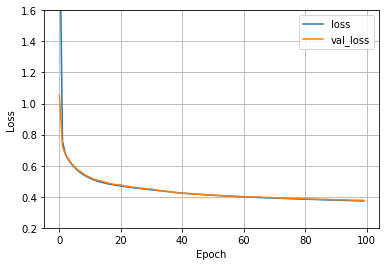

In [343]:
plot_loss(history)

We can see that although the training loss (blue line) decreases until the end of the training process, the validation loss plateaus much earlier. The model probably starts to overfit at around epoch 25 or so.

## Evaluation on test data

Using the `evaluate()` method of the model on the test data, we can get the evaluation metrics, here MSE. 

In [344]:
mse_test = model.evaluate(X_test_scaled, y_test)

129/129 [==============================] - 0s 773us/step - loss: 0.3870 - mse: 0.3870


The mean squared error on the test data seems to be the same as for the validation data. So we can conclude, that the model generalizes well to unseen data.

## Making predictions

Finally, let us make some predictions on the test data using the `predict()` method. And display the first 10 results.

In [345]:
y_pred = model.predict(X_test_scaled)
y_pred[0:5]

array([[0.6888725],
       [1.7078247],
       [3.5952587],
       [2.7903302],
       [2.6968858]], dtype=float32)

And also output the real target values to compare them.

In [346]:
y_test[0:5]

array([0.477  , 0.458  , 5.00001, 2.186  , 2.78   ])

Be reminded, that the predicted housing prices are in \\$100.000. Although the predicted results seem to be quite off, the model still follows the general trend of the prices. High prices are high, and low prices are low.

The next function takes the true target values and the predicted house prices and plots a scatterplot.

In [347]:
def plot_diff(y_true, y_pred, title = 'Linear_Regression'):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis = ('equal')
    plt.axis = ('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-500, 500], [-500, 500])

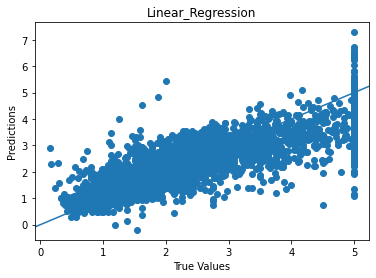

In [348]:
plot_diff(y_test, y_pred)

We can see that the model follows the general trend.